In [1]:
from brian2 import *
from util.visualization_functions import *
from util.analysis_functions import *
import brian2.numpy_ as np
from networkx import nx
%matplotlib inline

#set_device('cpp_standalone', clean=True) # for C++ speedup
# prefs.devices.cpp_standalone.openmp_threads = 4 # number of threads; needs openmp

In [2]:
# recreate the simulation used in Ocker 2015, adding inhibitory neurons

start_scope()

# model parameters
gL = .1 * msiemens * cm**-2                # leak conductance
vL = -72 * mV                              # leak reversal potential
C = 1 * ufarad * cm**-2                    # membrane capacitance
delta = 1.4 * mV                           # action potential steepness
vT = -48 * mV                              # action potential initiation threshold
mu = 1 * uamp * cm**-2                     # noise mean
sigma = 9 * mV                             # noise std dev
tau_s = 5 * ms                             # synaptic time constant
           
# other cell params           
vTh = 30 * mV                              # spike threshold
vR = -72 * mV                              # reset potential
tRef = 2 * ms                              # action potential width (refractory time)
           
# network params           
p = 0.15                                   # connection density
N_exc = 800                                # number exc neurons
N_inh = 200                                # number inh neurons
N_network = N_exc + N_inh                  # number of neurons

# simulation params
sim_time_ms = 1000 * 10 * 1                # simulation time in ms
monitor_dt_ms = sim_time_ms / 100          # timestep for monitor evaluation

######################
#                    #
#   init the model   #
#                    #
######################
dynamics = '''
dv/dt = (gL * (vL - v) + gL * delta * exp((v - vT) / delta) + (mu + gL * sigma * sqrt(2 * C / gL) * xi) + j_e - j_i) / C : volt (unless refractory)
dj_e/dt = -j_e/tau_s : amp * meter ** -2
dj_i/dt = -j_i/tau_s : amp * meter ** -2
'''

neurons = NeuronGroup(N_network, dynamics, 
                threshold='v > vTh',
                reset='v = vR',
                refractory='tRef',
                method='euler')

neurons_exc = neurons[:N_exc]
neurons_inh = neurons[N_exc:(N_exc + N_inh - 1)]

synapses_exc = Synapses(neurons_exc, neurons,
                    '''w : amp * meter**-2
                        dApre/dt = -Apre / tauPre : amp * meter**-2 (event-driven)
                        dApost/dt = -Apost / tauPost : amp * meter**-2 (event-driven)''',
                    on_pre='''j_e += w
                        Apre += dApre / (N_network*p)
                        w = clip(w + Apost, 0, wMax)''',
                    on_post='''Apost += dApost / (N_network*p)
                        w = clip(w + Apre, 0, wMax)''')

synapses_inh = Synapses(neurons_inh, neurons,
                       '''w : amp * meter**-2''',
                       on_pre='''j_i += w''')
           
# connect synapses
synapses_exc.connect(condition='i!=j', p=p)
synapses_inh.connect(condition='i!=j', p=p)

# get connection density (for use in STDP params)
p0 = p #compute_p0(neurons, synapses)

# stdp params
wMax = 5 * uamp * cm**-2            # max syn weight
tauPre = 5 * ms #15 * ms            # synaptic time constant
tauPost = 5 * ms #2 * tauPre        # synaptic time constant
dApre = .01
dApost = -dApre * tauPre / tauPost * 1.05
dApost *= wMax
dApre *= wMax

# assign synaptic weights
mu_w0 = wMax * 2 / (p0 * N_network)
sigma_w0 = mu_w0 / 10
synapses_exc.w = "mu_w0 + (0.5 - rand()) * sigma_w0"
synapses_inh.w = "mu_w0 + (0.5 - rand()) * sigma_w0"

# monitors
sp_mon_exc = SpikeMonitor(neurons_exc)
sp_mon_inh = SpikeMonitor(neurons_inh)
w_mon_exc = StateMonitor(synapses_exc, 'w', record=range(len(synapses_exc.w)), dt=monitor_dt_ms * ms)
w_mon_inh = StateMonitor(synapses_inh, 'w', record=range(len(synapses_inh.w)), dt=monitor_dt_ms * ms)

# initial voltage values
for i in range(N_network):
    neurons[i].v = (np.random.normal(0, 1) * (vTh-vR))

######################
#                    #
#   run simulation   #
#                    #
######################
run(sim_time_ms * ms, report='text')


WARNING    /Users/julienbloch/miniconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /Users/julienbloch/Library/Caches/cython/brian_extensions/_cython_magic_e8960b16157517882c96830725846949.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
 [py.warnings]
clang: warning: libstdc++ is deprecated; move to libc++ with a minimum deployment target of OS X 10.9 [-Wdeprecated]
ld: library not found for -lstdc++
clang: error: linker command failed with exit code 1 (use -v to see invocation)
WARNING    Cannot use Cython, a test compilation failed: command 'g++' failed with exit status 1 (LinkError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to a

Starting simulation at t=0. s for a duration of 10. s
2.0587 (20%) simulated in 10s, estimated 39s remaining.
4.1240000000000006 (41%) simulated in 20s, estimated 28s remaining.
6.2019 (62%) simulated in 30s, estimated 18s remaining.
8.129100000000001 (81%) simulated in 40s, estimated 9s remaining.
10.0 (100%) simulated in 49s


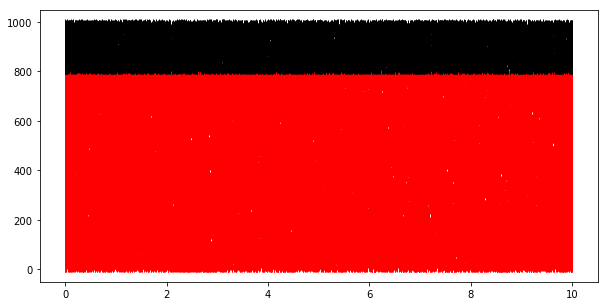

In [3]:
# spike trains
plt.figure(figsize=(10, 5))
plot(sp_mon_exc.t/second, sp_mon_exc.i, '|r')
plot(sp_mon_inh.t/second, sp_mon_inh.i + N_exc, '|k')
plt.show()

In [4]:
N = N_exc + N_inh
len_t = max(len(w_mon_exc.t), len(w_mon_inh.t))

W = np.zeros((N, N, len_t))
W[synapses_exc.i[:], synapses_exc.j[:], :] = w_mon_exc.w[:,:]
W[synapses_inh.i[:] + N_exc, synapses_inh.j[:], :] = w_mon_inh.w[:,:]

W_EE = W.copy()
W_EE[N_exc:, :, :] = 0
W_EE[:, N_exc:, :] = 0

W_II = W.copy()
W_II[:N_exc, :, :] = 0
W_II[:, :N_exc, :] = 0

W_IE = W.copy()
W_IE[:N_exc, :, :] = 0
W_IE[:, N_exc:, :] = 0

W_EI = W.copy()
W_EI[N_exc:, :, :] = 0
W_EI[:, :N_exc, :] = 0


In [5]:
W_EE = W_EE[:,:,1]
W_EI = W_EI[:,:,1]
W_IE = W_IE[:,:,1]
W_II = W_II[:,:,1]

In [6]:
p_EE = sum(W_EE) / N**2
p_EI = sum(W_EI) / N**2
p = (sum(W_EE) + sum(W_EI) + sum(W_IE) + sum(W_II)) / N**2

q_div_EE = sum(np.matmul(W_EE, W_EE.transpose())) / N**3 - p**2
q_div_IEI = sum(np.matmul(W_EI, W_EI.transpose())) / N**3 - p**2
q_div_EEI = sum(np.matmul(W_EI, W_EE.transpose())) / N**3 - p**2 # 0

q_con_EE = sum(np.matmul(W_EE.transpose(), W_EE)) / N**3 - p**2
q_con_EIE = sum(np.matmul(W_EI.transpose(), W_EI)) / N**3 - p**2    
q_con_EEI = sum(np.matmul(W_EE.transpose(), W_IE)) / N**3 - p**2 # 0

q_ch_EE = sum(np.matmul(W_EE, W_EE))/ N**3 - p**2
q_ch_IEE = sum(np.matmul(W_IE, W_EE))/ N**3 - p**2
q_ch_EIE = sum(np.matmul(W_EI, W_IE))/ N**3 - p**2
q_ch_EEI = sum(np.matmul(W_EE, W_EI))/ N**3 - p**2

q_rec_EE = sum(np.multiply(W_EE, W_EE.transpose())) / N**2 - p**2 # Element wise
q_rec_EI = sum(np.multiply(W_EI, W_IE.transpose())) / N**2 - p**2

In [7]:
for metric in (p_EE, p_EI, q_div_EE, q_div_IEI, q_div_EEI, q_con_EE, q_con_EIE, q_con_EEI, q_ch_EE, 
            q_ch_IEE, q_ch_EIE, q_ch_EEI, q_rec_EE, q_rec_EI):
    print(metric)

6.420751634442267e-05
1.6275424906734234e-05
-4.891209076339916e-09
-8.745179002314249e-09
-1.0078567645857214e-08
-4.886627316240297e-09
-9.738469113968429e-09
-1.0078567645857214e-08
-4.9251750793530175e-09
-8.800715163733043e-09
-8.782974839891373e-09
-8.771706042710521e-09
-3.4287362191174128e-09
-8.43454554538955e-09


In [8]:
print(-p**2)

-1.0078567645857214e-08


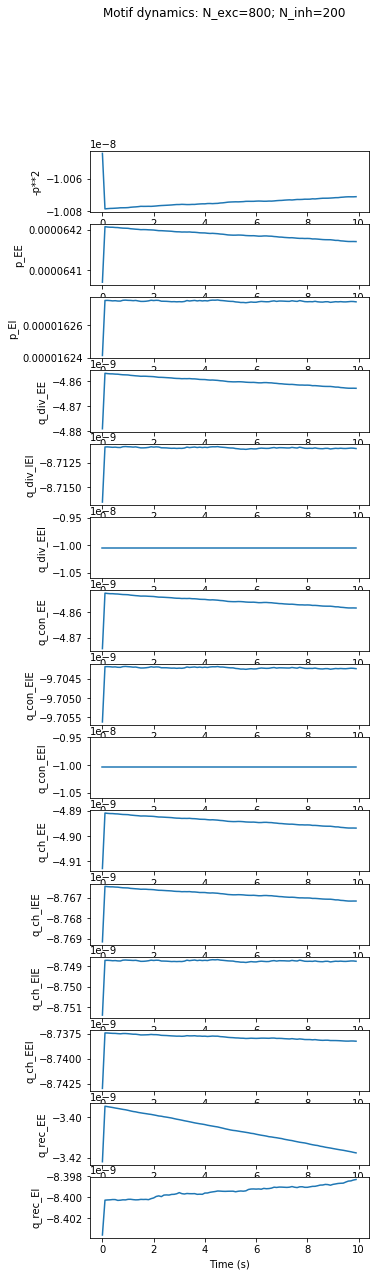

In [9]:
# individual IEI motifs
plot_all_motif_dynamics2(w_mon_exc, w_mon_inh, synapses_exc, synapses_inh, N_exc, N_inh, use_p0=True)

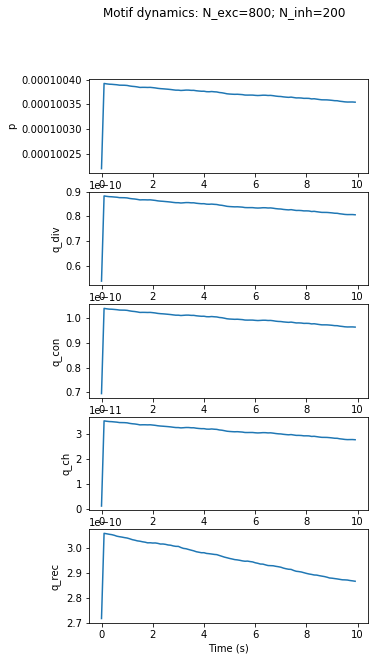

In [10]:
# figure 7
plot_motif_dynamics2(w_mon_exc, w_mon_inh, synapses_exc, synapses_inh, N_exc, N_inh, use_p0=True)

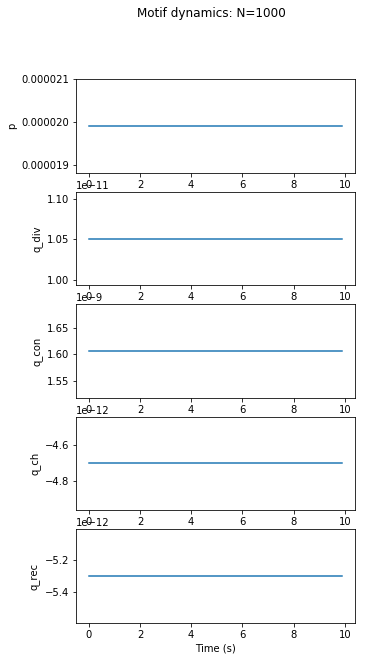

In [11]:
# just inhibitory motifs
plot_motif_dynamics(w_mon_inh, synapses_inh, N_network, use_p0=True)

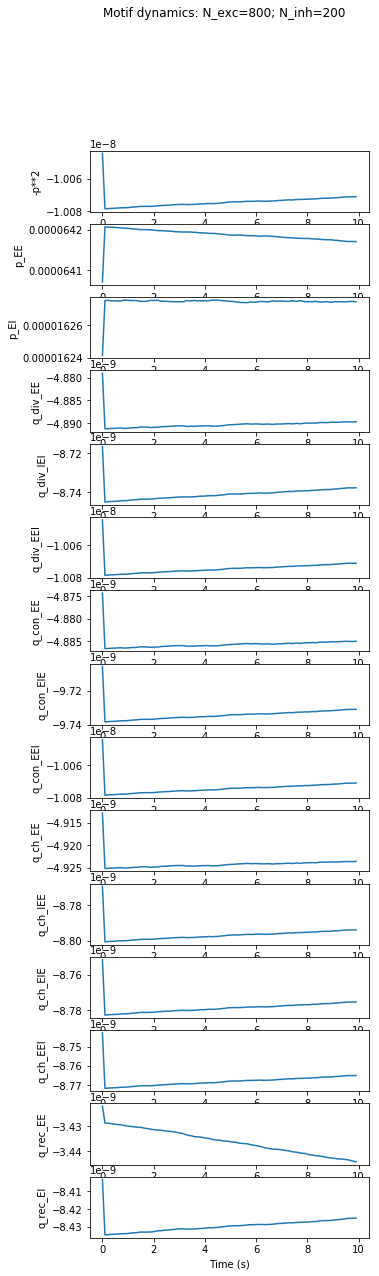

In [12]:
# individual IEI motifs
plot_all_motif_dynamics2(w_mon_exc, w_mon_inh, synapses_exc, synapses_inh, N_exc, N_inh, use_p0=False)

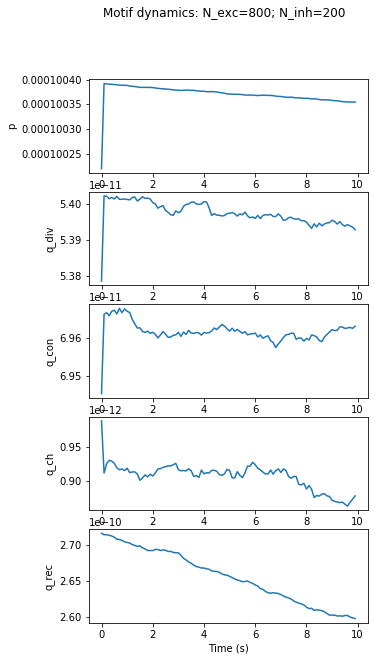

In [13]:
# figure 7
plot_motif_dynamics2(w_mon_exc, w_mon_inh, synapses_exc, synapses_inh, N_exc, N_inh, use_p0=False)

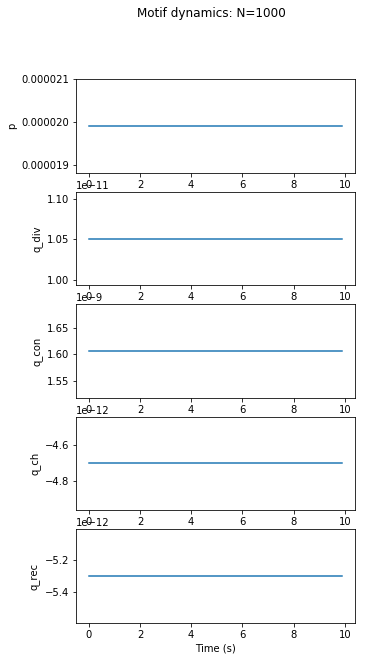

In [14]:
# just inhibitory motifs
plot_motif_dynamics(w_mon_inh, synapses_inh, N_network, use_p0=False)